In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torchvision.models as models
import torch
from tqdm import tqdm
from PIL import Image
from utils.image_utils import load_image
from utils.torch_utils import numpy_to_variable
from models.vgg import Vgg16
from attacks.dispersion import DispersionAttack_gpu
import numpy as np
import os
from matplotlib.pyplot import imshow

In [9]:
dataset_dir = "images"
outout_dir = "images_adv"
images_name = os.listdir(dataset_dir)

model = Vgg16()
internal = [i for i in range(29)]
# Initialize dipersion reduction attack
attack = DispersionAttack_gpu(model, epsilon=16./255, step_size=1./255, steps=1000)

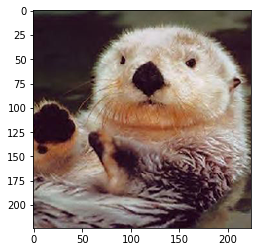

In [10]:
# Plot image
image = Image.open('./images/example.png')
imshow(image)


100%|██████████| 1/1 [00:15<00:00, 15.02s/it]

original_label:356, adv_label:746


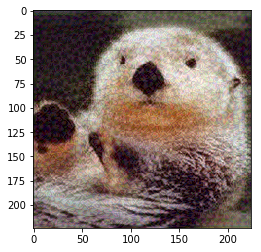

In [22]:

for idx, temp_image_name in enumerate(tqdm(images_name)):
    temp_image_path = os.path.join(dataset_dir, temp_image_name)
    image_np = load_image(data_format='channels_first', abs_path=True, fpath=temp_image_path)
    image = numpy_to_variable(image_np)
    original_label = np.argmax(model.model(image).detach().cpu().numpy())
    adv = attack(image, 
                 attack_layer_idx=14, 
                 internal=internal, 
                )
    adv_image = (np.transpose(adv[0].cpu().numpy(), (1, 2, 0)) * 255).astype(np.uint8)
    adv_image = Image.fromarray(adv_image)
    adv_image.save(os.path.join(outout_dir, temp_image_name))
    imshow(adv_image)
    adv_label = np.argmax(model.model(adv).detach().cpu().numpy())
    print('original_label:%d, adv_label:%d' % (original_label, adv_label))

In [24]:
import torchvision
dataset_dir = "./"

dataset_dir_ori = os.path.join(dataset_dir, 'images')
dataset_dir_adv = os.path.join(dataset_dir, 'images_adv')

images_name = os.listdir(dataset_dir_ori)

test_model = torchvision.models.densenet121(pretrained='imagenet').cuda().eval()

for idx, temp_image_name in enumerate(tqdm(images_name)):
    total_samples = len(images_name)
    ori_img_path = os.path.join(dataset_dir_ori, temp_image_name)
    adv_img_path = os.path.join(dataset_dir_adv, temp_image_name)

    image_ori_np = load_image(data_format='channels_first', shape=(224, 224), bounds=(0, 1), abs_path=True, fpath=ori_img_path)
    image_ori_var = numpy_to_variable(image_ori_np)
    gt_out = test_model(image_ori_var).detach().cpu().numpy()
    gt_label = np.argmax(gt_out)
    
    image_adv_np = load_image(data_format='channels_first', shape=(224, 224), bounds=(0, 1), abs_path=True, fpath=adv_img_path)
    image_adv_var = numpy_to_variable(image_adv_np)
    pd_out = test_model(image_adv_var).detach().cpu().numpy()
    pd_label = np.argmax(pd_out)

    print('idx: ', idx)
    print('ground truth: ', gt_label)
    print('prediction: ', pd_label)

/home/yunhan/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/yunhan/.torch/models/densenet121-a639ec97.pth

100%|██████████| 1/1 [00:00<00:00, 12.90it/s]

idx:  0
ground truth:  356
prediction:  296
